Pattern[1] belongs to class 2
Pattern[2] belongs to class 2
Pattern[3] belongs to class 2
Pattern[4] belongs to class 2
Pattern[5] belongs to class 2
Pattern[6] belongs to class 2
Pattern[7] belongs to class 2
Pattern[8] belongs to class 2
Pattern[9] belongs to class 2
Pattern[10] belongs to class 2
Pattern[11] belongs to class 2
Pattern[12] belongs to class 2
Pattern[13] belongs to class 2
Pattern[14] belongs to class 2
Pattern[15] belongs to class 2
Pattern[16] belongs to class 2
Pattern[17] belongs to class 2
Pattern[18] belongs to class 2
Pattern[19] belongs to class 2
Pattern[20] belongs to class 2
Pattern[21] belongs to class 2
Pattern[22] belongs to class 2
Pattern[23] belongs to class 2
Pattern[24] belongs to class 2
Pattern[25] belongs to class 2
Pattern[26] belongs to class 2
Pattern[27] belongs to class 2
Pattern[28] belongs to class 2
Pattern[29] belongs to class 2
Pattern[30] belongs to class 2
Pattern[31] belongs to class 2
Pattern[32] belongs to class 2
Pattern[33] belon

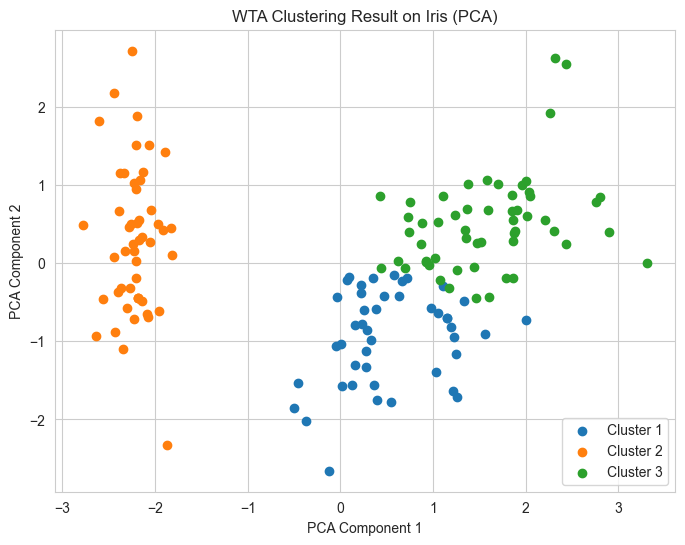

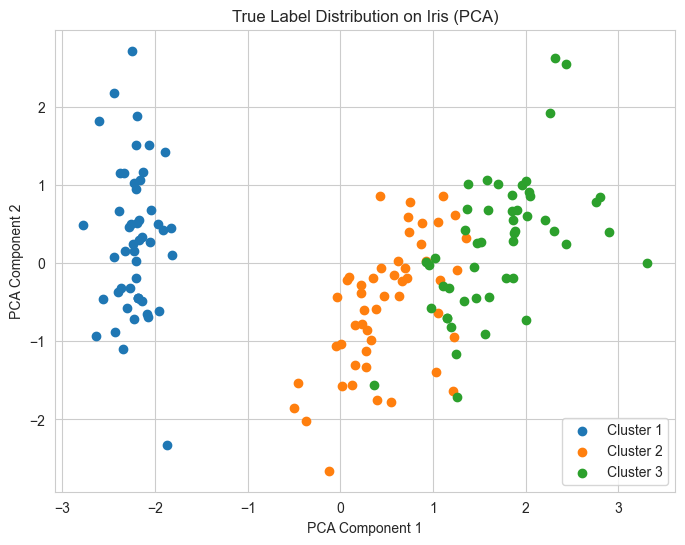


Cluster Confusion Table:
Predicted Cluster   0   1   2
True Class                   
0                   0  50   0
1                  34   0  16
2                  11   0  39

Clustering Accuracy (after optimal label alignment): 82.00%
Precision for class 0: 100.00%
Precision for class 1: 75.56%
Precision for class 2: 70.91%


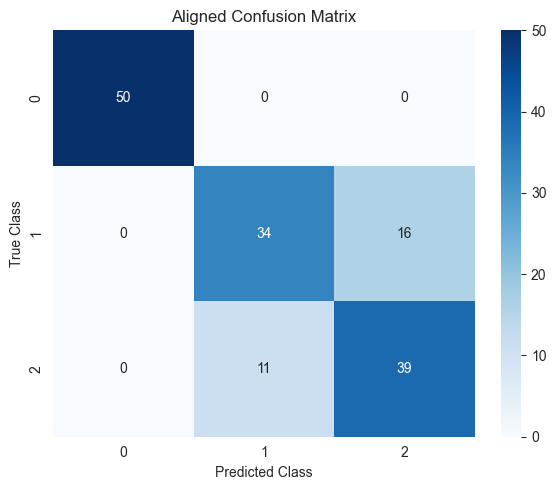

''

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score
from scipy.optimize import linear_sum_assignment
import seaborn as sns

# ---------- Step 1: Load and preprocess Iris data ----------
# 加载并标准化Iris数据集
def load_iris_data(path):
    """
    Load Iris data form file, extract features and labels, and normalize features using Z-score.
    读取Iris.dara，提取特征和标签，进行Z-score标准化处理
    """
    x_data = []     # feature list
    labels = []     # label list

    with open(path, 'r') as f:
        for line in f:
            if line.strip():    # skip empty lines
                parts = line.strip().split(',')
                features = list(map(float, parts[:4]))  # first 4 columns are features
                label = parts[4]    #last column is the label
                x_data.append(features)
                labels.append(label)
    x_data = np.array(x_data)
    # Normalize features to zero mean and unit variance 对特征进行标准化（零均值、单位方差）
    x_data = (x_data - np.mean(x_data, axis=0)) / np.std(x_data, axis=0)
    return x_data, labels

# Convert text labels to numeric values
def label_to_numeric(labels):
    label_map = {'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}
    return np.array([label_map[l] for l in labels])

# ---------- Step 2: Winner-Take-All learning ----------
# Winner-Take-All 无监督聚类学习 Unsupervised clustering using Winner-Take-All rule
def winner_take_all_learning(x, clus=3, alpha=0.1, n_update=100):
    """
    进行Winner-Take-All聚类学习。初始聚类中心随机选取，之后反复更新
    Perform Winner-Take-All learning with random weight initialization
    """
    pattern, input_d = x.shape
    rng = np.random.default_rng(seed=42) # 随机数生成器（可复现） Random generator (reproducible)

    # 随机选取初始权重向量 Randomly choose initial cluster centers
    indices = rng.choice(pattern, clus, replace=False)
    w = np.array([x[i] for i in indices])   # 聚类中心权重 Cluster center weights

    for _ in range(n_update):   # iterate for n_update epochs
        for p in range(pattern):
            s = np.dot(w, x[p])     # 计算每个权重与输入的相似度 Compute similarity to each weight vector
            m0 = np.argmax(s)       # 找到响应最强的聚类中心 Find the winning cluster
            w[m0] += alpha * (x[p] - w[m0])     # 按学习率更新该聚类中心 Update winner's weight
            w[m0] /= np.linalg.norm(w[m0])      # 将该权重单位化 Normalize the updated vector

    return w

# ---------- Step 3: Classification ----------
# 根据聚类中心对输入样本进行分类 Assign each sample to the nearest cluster center
def classify(x, w):
    result = []
    for p in range(x.shape[0]):
        s = np.dot(w, x[p])     # 计算与每个权重的相似度 Compute similarity with weights
        m0 = np.argmax(s)       # 找到最相似的类 Find best matching class
        result.append(m0 + 1)   # 输出为1起始索引 Use 1-based indexing for output
    return result

# ---------- Step 4: Visualization ----------
# 使用PCA将高维数据降到二维并绘图 Reduce dimensions with PCA and plot clusters
def plot_clusters(x, labels, title="Cluster Result"):
    pca = PCA(n_components=2)   # 主成分分析降到二维 PCA to reduce to 2D
    x_2d = pca.fit_transform(x)
    plt.figure(figsize=(8, 6))
    for i in range(1, max(labels)+1):   # 遍历每个聚类 Plot each cluster
        plt.scatter(x_2d[np.array(labels) == i, 0],
                    x_2d[np.array(labels) == i, 1],
                    label=f'Cluster {i}')

    plt.title(title)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend()
    plt.grid(True)
    plt.show()

# ---------- Step 5: Evaluate clustering performance ----------
# 对预测标签进行最佳对齐，并计算准确率和每类准确率
def evaluate_clustering(true_label, predicted_cluster):
    """
    使用匈牙利算法对聚类标签进行最优匹配，并评估精度
    Align predicted clusters labels using Hungarian algorithm and evaluate metrics.
    """
    # 构造混淆矩阵 Build confusion matrix
    confusion = pd.crosstab(pd.Series(true_label, name='True'),
                            pd.Series(predicted_cluster, name='Predicted'))

    cost_matrix = -confusion.values #使用负数最大化匹配数量 Use negative to maximize total matching
    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    # 生成预测标签与真实标签的映射关系 Map predicted cluster index to true label
    mapping = dict(zip(col_ind, row_ind))
    aligned_pred = [mapping[pred] for pred in predicted_cluster]  # 重新映射预测值 Aligned predictions

    # 计算准确率 Accuracy
    accuracy = accuracy_score(true_label, aligned_pred)

    # 每类准确率(precision) Precision for each class
    precision = precision_score(true_label, aligned_pred, average=None)

    return accuracy, precision, mapping, aligned_pred

# ---------- Step 6: Confusion Matrix Visualization ----------
# 可视化混淆矩阵 Visualize confusion matrix as heatmap
def plot_confusion_matrix(true_label, pred_labels):
    """
    绘制对齐后的混淆矩阵热图
    Plot heatmap for confusion matrix after alignment
    """
    matrix = pd.crosstab(pd.Series(true_label, name='True'),
                         pd.Series(pred_labels, name='Predicted'))
    plt.figure(figsize=(6, 5))
    sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Aligned Confusion Matrix")
    plt.ylabel("True Class")
    plt.xlabel("Predicted Class")
    plt.tight_layout()
    plt.show()

# ---------- Step 7: Main ----------
# Main Execution
iris_data, iris_labels = load_iris_data("iris.data")    # load data
true_labels = label_to_numeric(iris_labels)             # encode labels

# Train using WTA rule
weights = winner_take_all_learning(iris_data, clus=3, alpha=0.1, n_update=100)

# Classify all patterns based on trained weights
predicted_clusters = classify(iris_data, weights)
predicted_clusters_index = np.array(predicted_clusters) - 1     # convert to 0-based index

# output predicted class for each sample
for n, cls in enumerate(predicted_clusters):
    print(f"Pattern[{n+1}] belongs to class {cls}")

# plot clustering result
plot_clusters(iris_data, predicted_clusters, title="WTA Clustering Result on Iris (PCA)")
# plot true class distribution
plot_clusters(iris_data, true_labels+1, title="True Label Distribution on Iris (PCA)")

# Confusion matrix before alignment
df = pd.DataFrame({'TrueLabel': true_labels, 'PredictedCluster': predicted_clusters_index})
confusions = pd.crosstab(df['TrueLabel'], df['PredictedCluster'],
                        rownames=['True Class'], colnames=['Predicted Cluster'])
print("\nCluster Confusion Table:")
print(confusions)

# Evaluate accuracy and per-class precision
acc, precision_each_class, label_mapping, aligned_preds = evaluate_clustering(true_labels, predicted_clusters_index)
print(f"\nClustering Accuracy (after optimal label alignment): {acc * 100:.2f}%")
# print precision per class
for cls, prec in enumerate(precision_each_class):
    print(f"Precision for class {cls}: {prec * 100:.2f}%")

# Visualize confusion matrix after label alignment
plot_confusion_matrix(true_labels, aligned_preds)

input("Press ENTER to exit...")